# Customer Segmentation

Since our dataset is now close to 40 predictors it will be advantageous for us to summarize the variables that "collectively explain most of the variability in the original set", *(Intro. to Statistical Learning)* thus being able to look at them in a lower dimensional space. If we can find a decently low number of principle components we can plot each component against each other instead of having to plot 780 (40*39/2) different plots!

The first step will be to grab a sample of our dataset and scale it using `StandardScaler`. (A small sample of the dataset will provide a better interpretation of the customer segments when we look at the dendrogram later.) Since the values in the dataset are of different values, such as average euro balances that reach over 100,000 and the plethora of binary values of the one-hot-encoded variables, it is preferred to scale the dataset.

After scaling the dataset the next step will be to check how much variance of the dataset is explaining by the principle components. Then if we find that a handful of components will suffice, we can plot each component against each other to see if there is a noticable cluster of customers who either subscribed or did not.

If there are noticable clusters we can use KMeans Clustering to cluster each customer into their respective groups. If we do not notice a diffinitive cluster of customers, we can implement heirarchical clustering (dendrogram) to determine how many clusters we should use.

After we find the number of clusters that segment customers we will then look at each segment individually to determine which features are making them subscribe.

Let's see what we find!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage, cut_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
dummy_df = pd.read_parquet('../../Data/dummy-term-deposit-marketing.parquet')
dummy_df.head()

,age,default,balance,housing,loan,day,campaign,y,duration_minutes,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,0,4.350000,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,0,2.516667,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,0,1.266667,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,0,2.316667,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,0,3.616667,False,...,False,False,False,False,False,False,False,True,False,False


In [3]:
for col in dummy_df.columns:
    if dummy_df[col].dtype=='bool':
        dummy_df[col] = dummy_df[col].astype('category')

In [4]:
######## dataset comprised of random 10% of customers
seed = 4701

X_rand = dummy_df.sample(frac=.005, random_state=seed)

print(f"Length of sampled dataset: {X_rand.shape[0]}")
X_rand.head()

Length of sampled dataset: 192


,age,default,balance,housing,loan,day,campaign,y,duration_minutes,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
29508,35,0,694,0,0,9,2,0,0.483333,False,...,False,False,True,False,False,False,False,False,False,False
23187,37,0,0,1,0,17,1,0,1.283333,False,...,False,False,False,False,False,False,False,False,True,False
7255,46,0,583,1,0,30,3,0,2.250000,False,...,False,False,False,False,False,False,False,True,False,False
36156,32,0,684,1,0,14,3,1,10.116667,True,...,False,False,False,False,False,False,False,True,False,False
8792,50,0,416,1,0,5,5,1,8.233333,False,...,False,False,False,False,False,True,False,False,False,False


In [5]:
X_rand['y'].mean()

0.09895833333333333

In [6]:
y = X_rand['y'].values
X_rand = X_rand.drop('y', axis=1)

X_rand.head()

,age,default,balance,housing,loan,day,campaign,duration_minutes,job_admin,job_blue-collar,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
29508,35,0,694,0,0,9,2,0.483333,False,False,...,False,False,True,False,False,False,False,False,False,False
23187,37,0,0,1,0,17,1,1.283333,False,False,...,False,False,False,False,False,False,False,False,True,False
7255,46,0,583,1,0,30,3,2.250000,False,False,...,False,False,False,False,False,False,False,True,False,False
36156,32,0,684,1,0,14,3,10.116667,True,False,...,False,False,False,False,False,False,False,True,False,False
8792,50,0,416,1,0,5,5,8.233333,False,False,...,False,False,False,False,False,True,False,False,False,False


In [7]:
X_rand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 29508 to 14120
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  192 non-null    int8    
 1   default              192 non-null    int8    
 2   balance              192 non-null    int32   
 3   housing              192 non-null    int8    
 4   loan                 192 non-null    int8    
 5   day                  192 non-null    int8    
 6   campaign             192 non-null    int8    
 7   duration_minutes     192 non-null    float64 
 8   job_admin            192 non-null    category
 9   job_blue-collar      192 non-null    category
 10  job_entrepreneur     192 non-null    category
 11  job_housemaid        192 non-null    category
 12  job_management       192 non-null    category
 13  job_retired          192 non-null    category
 14  job_self-employed    192 non-null    category
 15  job_services         1

In [8]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_rand)

In [9]:
X = pd.DataFrame(X_scaled, columns=X_rand.columns)

X.std()[:5], X.mean()[:5]

(age        1.002614
 default    1.002614
 balance    1.002614
 housing    1.002614
 loan       1.002614
 dtype: float64,
 age        2.775558e-16
 default    5.551115e-17
 balance   -4.163336e-17
 housing    4.625929e-17
 loan       3.700743e-17
 dtype: float64)

In [10]:
# transposed_df = X.T

# transposed_df.head()

## Principle Component Analysis

In [11]:
pca = PCA(random_state=seed)
# tsne = TSNE(random_state=seed)

pca_ = pca.fit_transform(X)
# tsne_ = tsne.fit_transform(X)

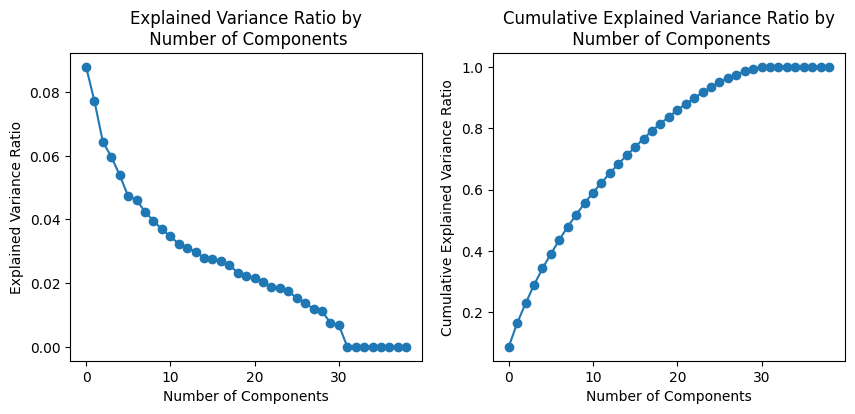

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].set_title('Explained Variance Ratio by\n Number of Components')

ax[1].plot(pca.explained_variance_ratio_.cumsum(), marker='o')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance Ratio')
ax[1].set_title('Cumulative Explained Variance Ratio by\n Number of Components')
plt.show()

The plot on the right shows the accumulative variance ratio vs the number of components. The total explained variance at around 6 components looks to be around 40% which isn't great, but 6 components as opposed to 39 is much more managable to visualize.

We will look at those 6 components below in regards to segmenting customers.

In [13]:
pca_df = pd.DataFrame({
    'PC 1': pca_[:, 0],
    'PC 2': pca_[:, 1],
    'PC 3': pca_[:, 2],
    'PC 4': pca_[:, 3],
    'PC 5': pca_[:, 4],
    'PC 6': pca_[:, 5],
}, index=X.index)

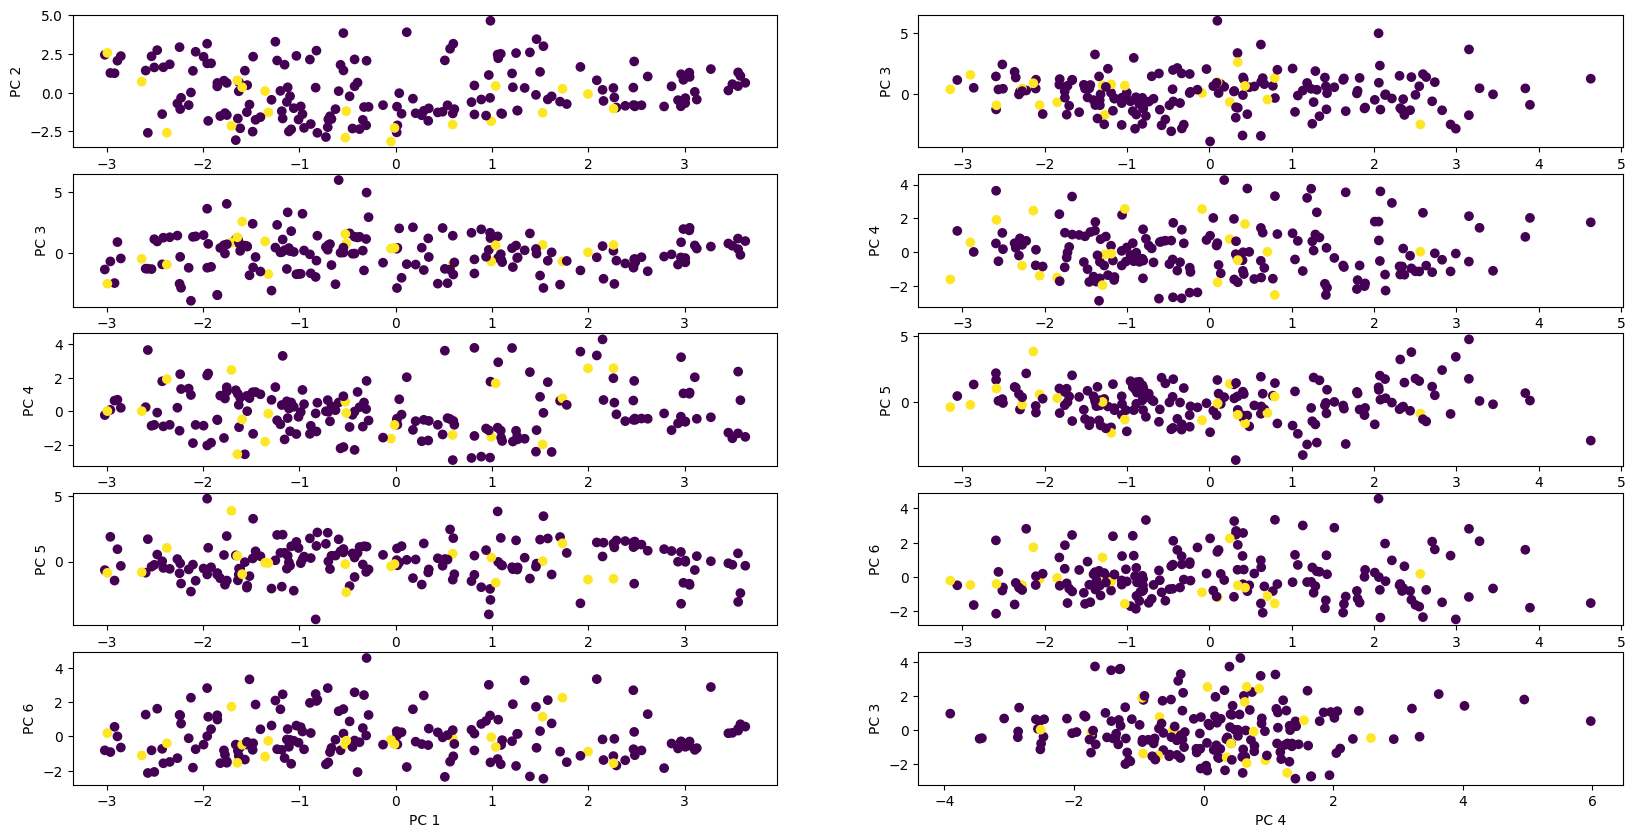

In [34]:
fig, axes = plt.subplots(5,2,figsize=(20,10), sharey=False)

# plt.title('Principle Components Plotted Against One Another')
axes[0,0].scatter(pca_df['PC 1'], pca_df['PC 2'], c=y, marker='o')
axes[0,0].set_ylabel('PC 2')
axes[0,1].scatter(pca_df['PC 2'], pca_df['PC 3'], c=y, marker='o')
axes[0,1].set_ylabel('PC 3')
axes[1,0].scatter(pca_df['PC 1'], pca_df['PC 3'], c=y, marker='o')
axes[1,0].set_ylabel('PC 3')
axes[1,1].scatter(pca_df['PC 2'], pca_df['PC 4'], c=y, marker='o')
axes[1,1].set_ylabel('PC 4')
axes[2,0].scatter(pca_df['PC 1'], pca_df['PC 4'], c=y, marker='o')
axes[2,0].set_ylabel('PC 4')
axes[2,1].scatter(pca_df['PC 2'], pca_df['PC 5'], c=y, marker='o')
axes[2,1].set_ylabel('PC 5')
axes[3,0].scatter(pca_df['PC 1'], pca_df['PC 5'], c=y, marker='o')
axes[3,0].set_ylabel('PC 5')
axes[3,1].scatter(pca_df['PC 2'], pca_df['PC 6'], c=y, marker='o')
axes[3,1].set_ylabel('PC 6')
axes[4,0].scatter(pca_df['PC 1'], pca_df['PC 6'], c=y, marker='o')
axes[4,0].set_ylabel('PC 6')
axes[4,0].set_xlabel('PC 1')
axes[4,1].scatter(pca_df['PC 3'], pca_df['PC 4'], c=y, marker='o')
axes[4,1].set_xlabel('PC 4')
axes[4,1].set_ylabel('PC 3')

plt.show()

Above, a combination of principle components are plotted against each other to see if any cluster emerge. As we can see there is not definitive cluster among those who subscribed and those who did not. With that being said the next step will be to use heirarchical clustering to see if there are any patterns that emerge to shine a light on how many segments to place our customers into.

Before that though let's transpose the principle components and look at the features in the dataset to see if certain features cluster together.

In [35]:
pca_T = pd.DataFrame(pca_, columns=X.columns).T
pca_T.head(10)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
age,-2.227797,-1.625954,1.250192,0.591514,1.997071,3.006274,-1.030579,-1.782386,-1.957295,-1.659892,...,-1.643763,1.393997,3.048860,-1.544722,2.469327,3.630230,2.987425,0.938901,0.344284,-0.951049
default,-0.334039,0.668125,2.550086,-2.061375,-0.088601,-0.678227,2.369848,0.771684,3.154493,-3.062347,...,0.794739,2.595265,1.288093,-1.257502,-0.802488,0.629965,0.826302,-1.479729,-1.013352,-2.274263
balance,-2.847545,0.784628,0.611446,-0.933624,0.058275,-0.413142,-1.737752,0.642578,3.628249,1.121671,...,1.289478,1.603356,1.852607,0.554982,-1.200062,0.976602,1.961724,-0.301249,-0.326460,0.206285
housing,1.326736,-0.935352,-1.144295,-1.391958,2.550552,-0.609964,-1.338029,-1.572812,2.130500,1.255742,...,-2.535179,2.327786,1.046108,0.922414,-0.499266,-1.505013,1.068178,-1.010399,-0.559161,0.430447
loan,-1.672260,-0.539568,1.603891,0.595745,-1.366404,0.073905,1.487704,0.493187,4.764844,0.467290,...,0.420811,-1.291995,-1.683043,-1.979799,1.091314,-0.320483,-1.613374,0.865155,-0.599382,0.375561
day,0.737877,-0.546435,-1.727230,-0.108744,-0.891162,-0.462003,0.624204,-0.818652,2.807947,-0.484408,...,-1.545126,-2.337330,-0.534534,-0.324124,-0.751722,0.564141,-0.413782,0.894347,0.448355,-0.758979
campaign,0.473481,-0.459921,-0.740435,-1.196141,-0.932894,-0.367836,-0.265011,-0.290225,-0.142993,-0.056113,...,0.243318,-0.246966,1.679108,-2.050326,-1.530140,0.856778,1.896695,-1.995981,-1.981046,-0.418945
duration_minutes,0.484463,0.999843,-0.245432,1.109236,-0.101322,-0.118513,-0.985750,-0.007117,-0.155309,-0.967815,...,0.219786,2.071712,-0.930641,-1.230738,1.292646,-0.853266,-0.825684,-0.039334,-0.230394,0.433623
job_admin,1.141552,-1.848861,-0.658762,-0.770191,0.145476,-0.205358,0.334950,-0.027119,2.892526,-0.513620,...,-0.149980,-2.441337,0.010749,0.021647,-0.681864,-0.288372,-0.250423,-0.391715,0.131964,-0.510250
job_blue-collar,-0.832109,-0.243945,0.044447,-0.316678,0.519306,0.328751,0.841765,2.140250,2.017831,2.247766,...,1.197228,2.298136,-0.152942,-1.413822,-0.843558,-0.492472,0.502333,0.039588,-0.792839,-0.075316


In [36]:
pca_T = pca_T.iloc[:, 0:5]
pca_T.head()

,0,1,2,3,4
age,-2.227797,-1.625954,1.250192,0.591514,1.997071
default,-0.334039,0.668125,2.550086,-2.061375,-0.088601
balance,-2.847545,0.784628,0.611446,-0.933624,0.058275
housing,1.326736,-0.935352,-1.144295,-1.391958,2.550552
loan,-1.672260,-0.539568,1.603891,0.595745,-1.366404


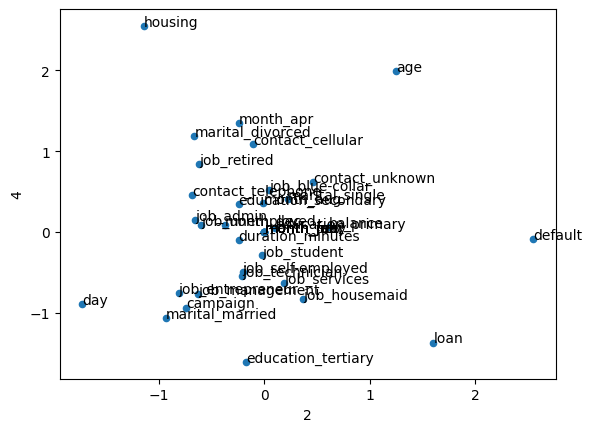

In [37]:
pca_T[[2, 4]].plot(x=2, y=4, kind='scatter')

for feature, z1, z2 in list(zip(pca_T.index.tolist(), pca_T[2].tolist(), pca_T[4].tolist())):
    plt.annotate(feature, xy=(z1, z2))

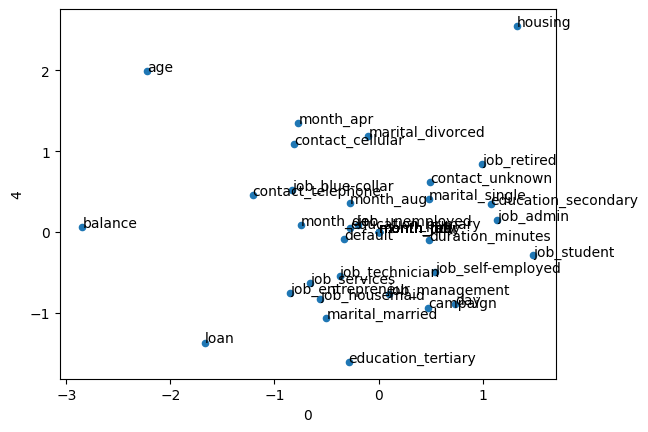

In [38]:
pca_T[[0, 4]].plot(x=0, y=4, kind='scatter')

for feature, z1, z2 in list(zip(pca_T.index.tolist(), pca_T[0].tolist(), pca_T[4].tolist())):
    plt.annotate(feature, xy=(z1, z2))

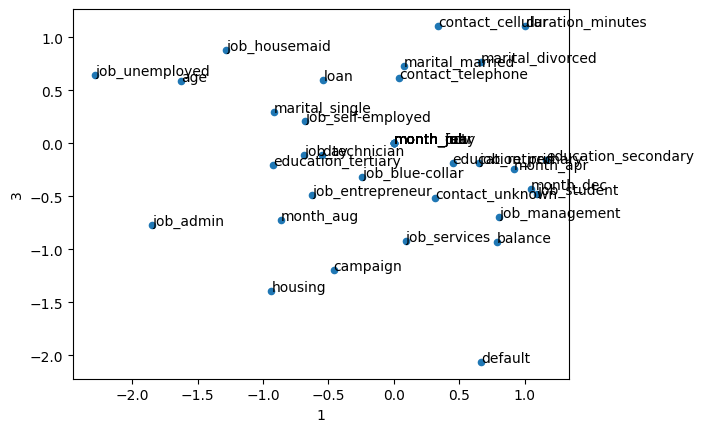

In [39]:
pca_T[[1, 3]].plot(x=1, y=3, kind='scatter')

for feature, z1, z2 in list(zip(pca_T.index.tolist(), pca_T[1].tolist(), pca_T[3].tolist())):
    plt.annotate(feature, xy=(z1, z2))

Looking at a few of the combinatiosn of the princeiple components we can see that a few features are seperated from the others: default, housing, loan, age. These might be helpful in determining which feature is common among those who subscribed.

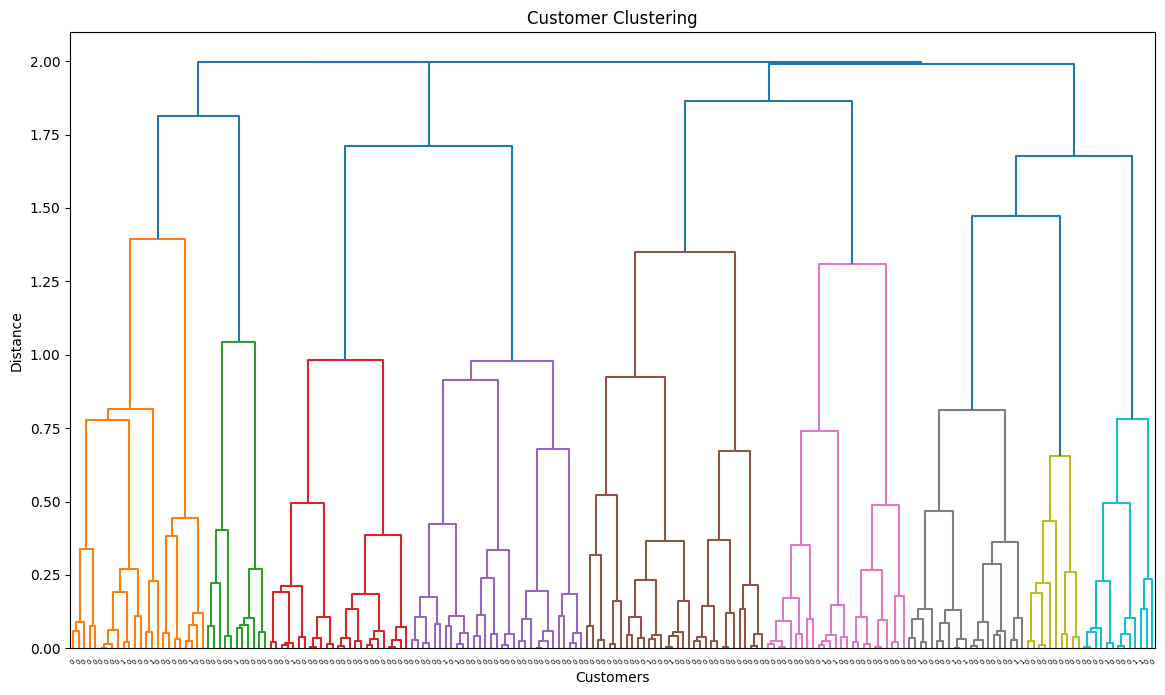

In [40]:
from sklearn.cluster import AgglomerativeClustering

HClust = AgglomerativeClustering

plt.figure(figsize=(14,8))

linkage_ = linkage(pca_df.iloc[:, 1:],
                   method='complete',
                   metric='correlation',
                   )

## transposed dataframe (for features)
# linkage_ = linkage(pca_T,
#                    method='complete',
#                    metric='correlation',
#                    )

dendrogram(linkage_,
           labels=y,
           # labels=pca_T.index,
        #    p=5,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_rotation=45
           )

plt.ylabel('Distance')
plt.xlabel('Customers')
plt.title('Customer Clustering')
plt.show()

Because we sampled from the dataset we can get a better look at where the subscribers and non-subscribers are being placed. It might not be totally clear on how many clusters we should use. We could use either 4 or 8 just by a rough look at where the trees are fusing together. But we will use 4 so as to get less of a uniform distribution of the subscribers.

In [41]:
comp_cut = cut_tree(linkage_, n_clusters=4).reshape(-1)

In [42]:
comp_cut

array([0, 1, 1, 0, 2, 0, 1, 1, 0, 3, 1, 0, 3, 0, 0, 2, 0, 0, 0, 1, 2, 1,
       1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 1, 1, 3, 2, 3, 1, 1, 0, 3, 1, 3, 2,
       1, 2, 0, 1, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0, 3, 0, 0, 1, 3, 3, 0, 3,
       2, 0, 3, 0, 3, 2, 3, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 0, 3, 2,
       1, 0, 2, 3, 2, 2, 0, 3, 3, 1, 1, 0, 3, 1, 2, 2, 3, 3, 0, 1, 1, 3,
       2, 2, 0, 1, 3, 0, 0, 2, 1, 3, 1, 3, 2, 3, 2, 3, 0, 0, 0, 2, 3, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 3, 3, 1, 3, 0, 2, 3, 1, 1, 0, 1, 0, 0,
       2, 2, 1, 3, 0, 3, 1, 1, 2, 0, 3, 1, 3, 3, 3, 3, 2, 3, 0, 3, 0, 2,
       1, 1, 0, 3, 1, 2, 1, 2, 2, 3, 0, 1, 2, 0, 0, 3])

In [43]:
pd.crosstab(y,
        pd.Series(comp_cut.reshape(-1), name='Complete'))

Complete,0,1,2,3
row_0,,,,
0,53,53,31,36
1,4,3,4,8


What this table is saying is that for the dendrogram above, the orange and green branches have 4 subscribers; the red and purple branches have 3 subscribers; the brown and pink branches have 4 and the rest have 8 subscribers.

In [44]:
X_rand['hierarch_label'] = comp_cut
X_rand['y'] = y

## KMeans

In [45]:
kmeans = KMeans(n_clusters=4, random_state=seed, n_init=50)
kmeans.fit(pca_df.iloc[:, 1:])

KMeans(n_clusters=4, n_init=50, random_state=4701)

In [46]:
pd.crosstab(pd.Series(comp_cut, name='HClust'),
            pd.Series(kmeans.labels_, name='K-means'))

K-means,0,1,2,3
HClust,,,,
0,13,7,32,5
1,7,34,15,0
2,2,2,5,26
3,5,2,35,2


The table above shows the difference between kmeans clustering and hierarchical clustering.
The overlap in clusters can be expressed as:

    KMeans cluster 0 shares a lot of the subscribers in cluster 0, but also has some overlap in the other three clusters. And cluster 1 shares a lot of subscribers with some overlap in the other three.

## Looking at Customers via their cluster

Using the same steps as before we will take the whole dataset and label each customer with their respective group label and then look at some of the statistics in each group to get a rough idea on what makes them subscribe.

In [27]:
y = dummy_df['y'].values
X = dummy_df.drop('y', axis=1)

In [28]:
X_scaled_whole = scaler.fit_transform(X)
pca_ = pca.fit_transform(X_scaled_whole)

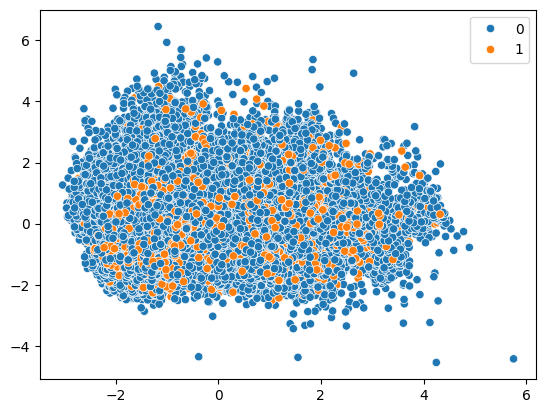

In [125]:
sns.scatterplot(pd.DataFrame(pca_), x=pca_[:, 2], y=pca_[:, 5], hue=y)
plt.show()

In [29]:
linkage_ = linkage(pca_[:, :6],
                   method='complete',
                   metric='correlation',
                   )

In [30]:
comp_cut = cut_tree(linkage_, n_clusters=4).reshape(-1)

In [31]:
pd.crosstab(y,
        pd.Series(comp_cut.reshape(-1), name='Complete'))

Complete,0,1,2,3
row_0,,,,
0,12047,4222,12673,6601
1,508,625,1287,372


The secondary goal of the project is to try and find customers who are more likely to subscribe and to find segments of the customers whom the bank should prioritize. The table shows that cluster 2 has the most subscribers of any of the other three groups. On a relative basis, group 1 has the biggest percentage of subscribers at 14.8%, followed by group 2 at 10.2%, then group3 at 5.6% and lastly group 0 at over 4%.

Focusing of segments 1 and 2 are suggested since the subscription rate in these two groups are above the average subscription rate of 7%.

Below we will try to look for features that stand out in these two groups.

In [61]:
df = pd.read_parquet('../../Data/term-deposit-marketing-2020-amended.parquet')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,y,duration_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,0,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,0,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,0,1.266667
3,35,management,married,tertiary,0,231,1,0,unknown,5,may,1,0,2.316667
4,28,management,single,tertiary,0,447,1,1,unknown,5,may,1,0,3.616667


In [62]:
df['cluster'] = comp_cut

In [65]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,y,duration_minutes,cluster
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,0,4.350000,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,0,2.516667,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,0,1.266667,0
3,35,management,married,tertiary,0,231,1,0,unknown,5,may,1,0,2.316667,0
4,28,management,single,tertiary,0,447,1,1,unknown,5,may,1,0,3.616667,0


In [66]:
df.to_csv('../../Data/modified_term_subscribers_labels.csv', index=False)

## Clusters

In [49]:
df.groupby('cluster')['education'].value_counts(normalize=True)

cluster  education
0        secondary    0.578017
         tertiary     0.218718
         primary      0.203266
1        secondary    0.519290
         tertiary     0.463586
         primary      0.017124
2        tertiary     0.434527
         secondary    0.408596
         primary      0.156877
3        secondary    0.782016
         primary      0.200631
         tertiary     0.017353
Name: proportion, dtype: float64

In [50]:
df.groupby('cluster')['job'].value_counts(normalize=True)

cluster  job          
0        blue-collar      0.295659
         management       0.158264
         technician       0.144484
         admin            0.118757
         services         0.112704
         retired          0.050179
         entrepreneur     0.034329
         self-employed    0.032019
         housemaid        0.025647
         unemployed       0.024054
         student          0.003903
1        management       0.255003
         technician       0.216216
         blue-collar      0.138230
         admin            0.130184
         services         0.089953
         student          0.074066
         self-employed    0.041469
         unemployed       0.024139
         entrepreneur     0.022076
         housemaid        0.007634
         retired          0.001032
2        management       0.334026
         blue-collar      0.210888
         technician       0.123138
         admin            0.084957
         services         0.069771
         entrepreneur     0.0473

In [51]:
df.groupby('cluster')[['age', 'balance', 'day', 'loan', 'housing', 'default', 'duration_minutes']].mean()

,age,balance,day,loan,housing,default,duration_minutes
cluster,,,,,,,
0,40.875587,1190.893349,15.440701,0.161609,0.733971,0.022222,4.212559
1,33.128739,1166.997731,16.469362,0.139261,0.637508,0.017124,4.579472
2,41.423567,1595.392407,13.948567,0.153725,0.576862,0.012751,4.342234
3,42.494479,812.870644,20.873942,0.279363,0.411444,0.033845,3.914931


No features are showing a clear distinction between groups. Further exploration might be needed to assess which features make subscribers subscribe.